In [1]:
import os,glob,csv

def hpd(data, level=0.95):
    """
    Return highest posterior density interval from a list,
    given the percent posterior density interval required.
    """
    d = list(data)
    d.sort()

    nData = len(data)
    nIn = int(round(level * nData))
    if nIn < 2 :
        return None
    #raise RuntimeError("Not enough data. N data: %s"%(len(data)))
 
    i = 0
    r = d[i+nIn-1] - d[i]
    for k in range(len(d) - (nIn - 1)) :
        rk = d[k+nIn-1] - d[k]
        if rk < r :
            r = rk
            i = k

    assert 0 <= i <= i+nIn-1 < len(d)
 
    return (d[i], d[i+nIn-1])

base_path='/mnt/c/Users/evogytis/repos/orthomyxo-metagenomics/data/full-segs/beast'

data={'minimal': {}, 'public': {}}

for f in glob.glob(os.path.join(base_path,'*.log.txt')):
#     print(f)
    fname=os.path.basename(f).split('.')[0]
#     print(fname)
    segment=fname.split('-')[0]
    
    rates=[]
    for l in csv.DictReader(open(f,'r'),fieldnames=['state','joint', 'prior', 'likelihood', 'treeModel.rootHeight', 'age(root)', 'treeLength', 'constant.popSize', 'gtr.rates.rateAC', 'gtr.rates.rateAG', 'gtr.rates.rateAT', 'gtr.rates.rateCG', 'gtr.rates.rateCT', 'gtr.rates.rateGT', 'frequencies1', 'frequencies2', 'frequencies3', 'frequencies4', 'alpha', 'clock.rate', 'meanRate', 'age(QN3-6|Culex_quinquefasciatus|CHN|2013)', 'treeLikelihood', 'branchRates', 'coalescent'],delimiter='\t'):
#         print(l)
        if '#' not in l['state'] and 'state' not in l['state'] and int(l['state'])>=5000000:
            rates.append(float(l['meanRate']))
    
    if 'SE' in fname:
        data['minimal'][segment]=rates
    elif 'NJ' in fname:
        data['public'][segment]=rates
        

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


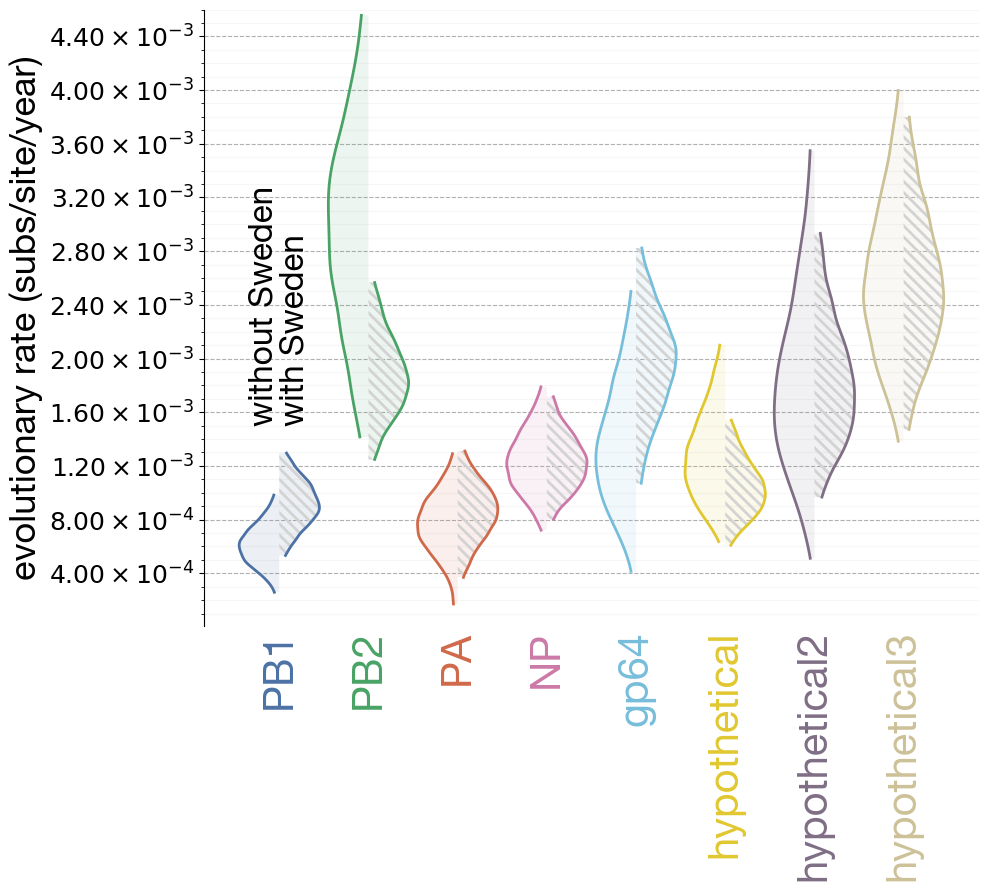

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec

# import baltic as bt

typeface='Helvetica Neue'
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.weight']=400
mpl.rcParams['axes.labelweight']=400
mpl.rcParams['font.size']=22
mpl.rcParams['pdf.fonttype']=42
# mpl.rcParams['text.usetex']=True

import numpy as np

from scipy.stats import gaussian_kde
# from matplotlib.patches import Rectangle


colours={'PB1': "#4c72a5", 
         'PB2': "#48a365", 
         'PA': "#d0694a", 
         'NP': "#cc79a7", 
         'gp64': "#77bedb", 
         'hypothetical': "#e1c72f", 
         'hypothetical2': "#7f6e85", 
         'hypothetical3': "#ccc197"}


fig = plt.figure(figsize=(10, 8),facecolor='w') 

cols=2
gs = GridSpec(1,1,wspace=0.05,hspace=0.05)
ax=plt.subplot(gs[0],facecolor='none')

segments=['PB1','PB2','PA','NP','gp64','hypothetical','hypothetical2','hypothetical3']

ax.set_xticks(range(len(segments)))
ax.set_xticklabels(segments,size=30)
for t in ax.get_xticklabels():
    t.set_color(colours[t.get_text()])

mpl.rcParams["hatch.color"]='lightgrey'
mpl.rcParams["hatch.linewidth"]=2
    
for s,seg in enumerate(segments):
    
    i=s
    j=s%cols
    
    scale=0.45
    fc=colours[seg]
    
    hpdlo,hpdhi=hpd(data['minimal'][seg])
    kde=gaussian_kde(data['minimal'][seg])
    y_grid=np.linspace(hpdlo,hpdhi,100)
    x_grid=kde(y_grid)
    x_grid=x_grid/x_grid.max()*scale
    
    ax.plot([i-x for x in x_grid],y_grid,lw=2,color=fc,zorder=100)
    ax.fill_betweenx(y_grid,[i-x for x in x_grid],[i for x in x_grid],facecolor=fc,edgecolor='none',alpha=0.1,zorder=10)
    
#     ax.text(i,5e-3,seg,color=fc,size=30,ha='center',va='top')
    
#     ax.set_yticks([])
#     ax.set_yticklabels([])
    
#     hpdlo,hpdhi=hpd(np.mean(data['public'][seg]))
    
#     print(seg,,np.mean(data['public'][seg]))
    hpdlo,hpdhi=hpd(data['public'][seg])
    kde=gaussian_kde(data['public'][seg])
    y_grid=np.linspace(hpdlo,hpdhi,100)
    x_grid=kde(y_grid)
    x_grid=x_grid/x_grid.max()*scale
    
    ax.plot([i+x for x in x_grid],y_grid,lw=2,color=fc,ls='-',zorder=100)
    ax.fill_betweenx(y_grid,[i+x for x in x_grid],[i for x in x_grid],facecolor=fc,hatch='\\\\\\',edgecolor='none',alpha=0.1,zorder=10)
    
    
    if i==0:
        ax.text(i,1.5e-3,'without Sweden',size=24,rotation=90,ha='left',va='bottom',rotation_mode='anchor')
        ax.text(i,1.5e-3,'with Sweden',size=24,rotation=90,ha='left',va='top',rotation_mode='anchor')

#     print(seg, s//cols)
#     if s//cols!=3:
# #         ax.set_xticks([])
#         ax.set_xticklabels([])
#     else:
#         ax.set_xlabel('evolutionary rate (subs/site/year)',size=30)
        
#         if s%cols==0:
#             ax.set_ylabel('density',size=30)
        
ax.grid(axis='y',which='major',ls='--')
ax.grid(axis='y',which='minor',ls='-',alpha=0.2,color='lightgrey')

ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(4e-4))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1e-4))
ax.set_ylim(1.1e-5,4.6e-3)

fmt=lambda y,pos: '0.0' if (y==0.0 or y==np.nan) else r'$%.2f\times10^{%d}$'%(y*(10**-int(np.log10(y/10))),int(np.log10(y/10)))
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))

ax.tick_params(axis='x',size=0,rotation=90)
ax.tick_params(axis='y',labelsize=18)
ax.tick_params(axis='y',which='minor',labelsize=10)

#     ax.set_xlim(5e-6,5e-3)
[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['left']]

ax.set_ylabel('evolutionary rate (subs/site/year)',size=26)
# ax.set_yscale('log')

plt.savefig('/mnt/c/Users/evogytis/repos/orthomyxo-metagenomics/manuscript/JournalOfVirology-revision1/SuppFig3_segRates.png',bbox_inches='tight',dpi=300)
plt.savefig('/mnt/c/Users/evogytis/repos/orthomyxo-metagenomics/manuscript/JournalOfVirology-revision1/SuppFig3_segRates.tiff',bbox_inches='tight',dpi=100)
plt.savefig('/mnt/c/Users/evogytis/repos/orthomyxo-metagenomics/manuscript/JournalOfVirology-revision1/SuppFig3_segRates.pdf',bbox_inches='tight',dpi=300)
plt.savefig('/mnt/c/Users/evogytis/repos/orthomyxo-metagenomics/manuscript/JournalOfVirology-revision1/SuppFig3_segRates.eps',bbox_inches='tight',dpi=300)

plt.show()

In [3]:
# %%bash

# ta=/mnt/c/Users/evogytis/tools/BEASTv1.10.4/bin/treeannotator

# base_path=/mnt/c/Users/evogytis/repos/orthomyxo-metagenomics/data/full-segs/beast
# cd $base_path
# ls

# for tree in $base_path/*.trees.txt; do
#     input=$(basename $tree)
    
#     out=${input/.trees.txt/.mcc.tree} ## format output name

#     $ta -heights ca -burninTrees 1000 $input $out ## run tree annotator
    
# done;

In [4]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec

import baltic as bt

typeface='Helvetica Neue'
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.weight']=400
mpl.rcParams['axes.labelweight']=400
mpl.rcParams['font.size']=22
mpl.rcParams['pdf.fonttype']=42

import os,glob

base_path='/mnt/c/Users/evogytis/repos/orthomyxo-metagenomics/data/full-segs/beast'

trees={}
for tree_path in glob.glob(os.path.join(base_path,'*.tree')):
    print(tree_path)
    dset=os.path.basename(tree_path).split('.')[0]
    
    ll=bt.loadNexus(tree_path)
    ll.treeStats()
    trees[dset]=ll

/mnt/c/Users/evogytis/repos/orthomyxo-metagenomics/data/full-segs/beast/gp64-woutNJ-woutSE.mcc.tree

Tree height: 23.788635
Tree length: 114.594272
strictly bifurcating tree
annotations present

Numbers of objects in tree: 53 (26 nodes and 27 leaves)

/mnt/c/Users/evogytis/repos/orthomyxo-metagenomics/data/full-segs/beast/gp64-woutNJ.mcc.tree

Tree height: 41.767354
Tree length: 140.088888
strictly bifurcating tree
annotations present

Numbers of objects in tree: 61 (30 nodes and 31 leaves)

/mnt/c/Users/evogytis/repos/orthomyxo-metagenomics/data/full-segs/beast/gp64.mcc.tree

Tree height: 44.624349
Tree length: 155.513574
strictly bifurcating tree
annotations present

Numbers of objects in tree: 65 (32 nodes and 33 leaves)

/mnt/c/Users/evogytis/repos/orthomyxo-metagenomics/data/full-segs/beast/hypothetical-woutNJ-woutSE.mcc.tree

Tree height: 10.051228
Tree length: 74.353274
strictly bifurcating tree
annotations present

Numbers of objects in tree: 81 (40 nodes and 41 leaves)

/mnt/c

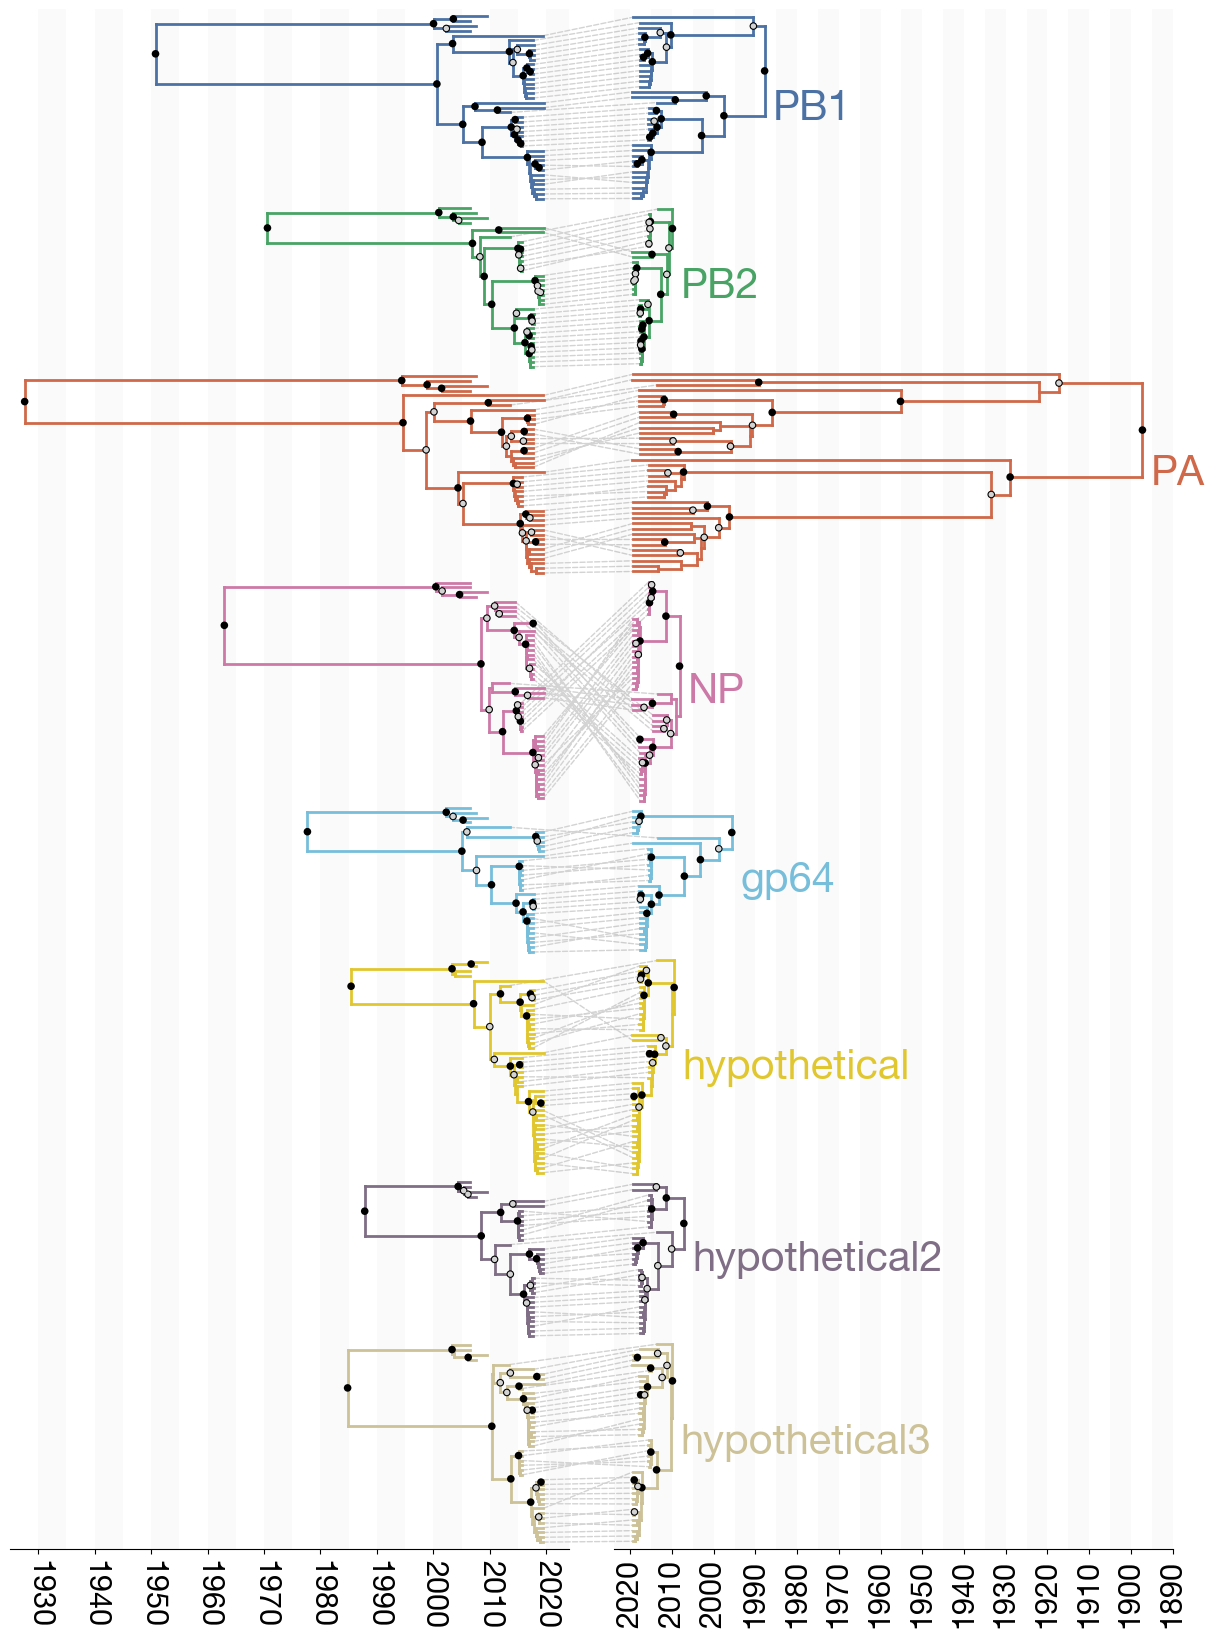

In [5]:
from matplotlib.patches import ConnectionPatch
import numpy as np

colours={'PB1': "#4c72a5", 
         'PB2': "#48a365", 
         'PA': "#d0694a", 
         'NP': "#cc79a7", 
         'gp64': "#77bedb", 
         'hypothetical': "#e1c72f", 
         'hypothetical2': "#7f6e85", 
         'hypothetical3': "#ccc197"}

segments=['PB1','PB2','PA','NP','gp64','hypothetical','hypothetical2','hypothetical3']


fig = plt.figure(figsize=(15, 20),facecolor='w') 
gs = GridSpec(1,2,wspace=0.08,hspace=0.05)

ax=plt.subplot(gs[0],facecolor='none')

cumulative_y=0

tip_positions={}

for s,seg in enumerate(segments[::-1]):
    x_attr=lambda k: k.absoluteTime
    y_attr=lambda k: k.y+cumulative_y
    
    key='%s-woutNJ'%(seg)
    ll=trees[key]
    
    if seg not in tip_positions: tip_positions[seg]={}
    for k in ll.getExternal():
        tip_positions[seg][k.name]=y_attr(k)
    
    
    ll.plotTree(ax,x_attr=x_attr,y_attr=y_attr,colour=colours[seg])
    ll.plotPoints(ax,target=lambda k: k.is_node() and k.traits['posterior']>=0.95,size=15,colour='k',x_attr=x_attr,y_attr=y_attr)
    ll.plotPoints(ax,target=lambda k: k.is_node() and 0.5<=k.traits['posterior']<=0.95,size=15,colour='lightgrey',x_attr=x_attr,y_attr=y_attr)
    
    
    cumulative_y+=ll.ySpan+1
    
ax.plot()

step=5
x_grid=range(1920,2030,step*2)
ax.set_xticks(x_grid)
ax.set_xticklabels(x_grid,rotation=-90)
[ax.axvspan(x,x+step,fc='k',ec='none',alpha=0.02,zorder=0) for x in x_grid]

ax.set_yticks([])
ax.set_yticklabels([])

ax.set_xlim(1925,2024)
ax.set_ylim(-1,cumulative_y)

[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]

#####################################
ax2=plt.subplot(gs[1],facecolor='none')

cumulative_y=0

for s,seg in enumerate(segments[::-1]):
    x_attr=lambda k: k.absoluteTime
    y_attr=lambda k: k.y+cumulative_y
    
    key='%s-woutNJ-woutSE'%(seg)
    ll=trees[key]
    
    ll.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,colour=colours[seg])
    ll.plotPoints(ax2,target=lambda k: k.is_node() and k.traits['posterior']>=0.95,size=15,colour='k',x_attr=x_attr,y_attr=y_attr)
    ll.plotPoints(ax2,target=lambda k: k.is_node() and 0.5<=k.traits['posterior']<=0.95,size=15,colour='lightgrey',x_attr=x_attr,y_attr=y_attr)
    
    for k in ll.getExternal():
        if k.name in tip_positions[seg]:
            ax.add_patch(ConnectionPatch(xyA=(k.absoluteTime,tip_positions[seg][k.name]),xyB=(k.absoluteTime,y_attr(k)),coordsA=ax.transData,coordsB=ax2.transData,color='lightgrey',ls='--'))
    
    ax2.text(ll.root.absoluteTime-2,cumulative_y+ll.ySpan/2,seg,size=30,color=colours[seg],ha='left',va='center')
    
    
    cumulative_y+=ll.ySpan+1
    
ax.plot()
ax2.plot()

step=5
x_grid=range(1860,2030,step*2)
ax2.set_xticks(x_grid)
ax2.set_xticklabels(x_grid,rotation=90)
[ax2.axvspan(x,x+step,fc='k',ec='none',alpha=0.02,zorder=0) for x in x_grid]

ax2.set_yticks([])
ax2.set_yticklabels([])

ax2.set_xlim(1890,2024)
ax2.set_ylim(-1,cumulative_y)
ax2.invert_xaxis()
[ax2.spines[loc].set_visible(False) for loc in ax2.spines if loc not in ['bottom']]
##################


plt.show()